In [27]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


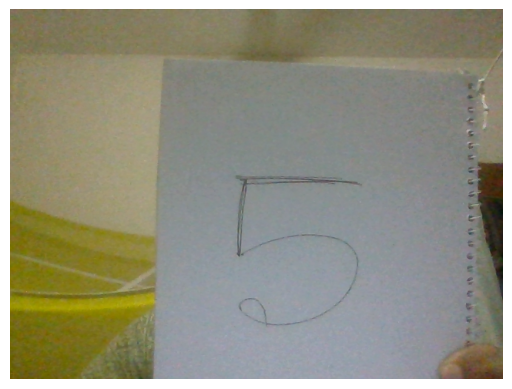

Predicted Digit: 5


In [32]:
# === Import Libraries ===
import cv2
import numpy as np
import io, base64
import matplotlib.pyplot as plt
from PIL import Image as PILImage
from tensorflow.keras.models import load_model
from google.colab.output import eval_js


# === Load Pre-trained MNIST Model ===
MODEL_PATH = "/content/drive/MyDrive/mnist_model.keras"
model = load_model(MODEL_PATH)


# === Helper Functions ===
def to_model_shape(img_28):
    """Normalize and reshape to (1, 28, 28, 1) for model input"""
    img_28 = img_28.astype("float32") / 255.0
    return img_28.reshape(1, 28, 28, 1)


def preprocess_mnist(frame_bgr):
    """
    Convert webcam frame (BGR) to MNIST-compatible input.
    Steps:
      1. Convert to grayscale + blur
      2. Adaptive threshold
      3. Find largest contour (digit area)
      4. Crop + resize to 28x28
    """
    gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    th = cv2.adaptiveThreshold(
        gray, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,
        11, 2
    )

    # Find largest contour
    cnts, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        return None, {"reason": "no contour found"}

    c = max(cnts, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(c)

    if w * h < 300:  # Ignore small noise
        return None, {"reason": "too small contour"}

    # Crop & resize digit
    roi = th[y:y+h, x:x+w]
    resized_roi = cv2.resize(roi, (28, 28), interpolation=cv2.INTER_AREA)

    return to_model_shape(resized_roi), {"bounding_box": (x, y, w, h)}


def take_picture():
    """Capture a single frame from webcam using JS"""
    js = """
    async function takePicture() {
        const video = document.createElement('video');
        video.width = 640; video.height = 480;
        const stream = await navigator.mediaDevices.getUserMedia({video: true});
        video.srcObject = stream;
        await new Promise(r => video.onloadedmetadata = r);
        video.play();
        const canvas = document.createElement('canvas');
        canvas.width = 640; canvas.height = 480;
        canvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
        const imageUrl = canvas.toDataURL('image/png');
        stream.getTracks().forEach(t => t.stop());
        return imageUrl;
    }
    takePicture();
    """
    return eval_js(js)


# === Main Pipeline ===
# Capture image
image_data = take_picture()
image_bytes = io.BytesIO(base64.b64decode(image_data.split(',')[1]))
img = PILImage.open(image_bytes)

# Display captured frame
plt.imshow(img)
plt.axis("off")
plt.show()

# Convert to OpenCV format
frame_bgr = np.array(img)

# Preprocess & predict
model_input, info = preprocess_mnist(frame_bgr)

if model_input is not None:
    prediction = model.predict(model_input, verbose=0)
    predicted_digit = np.argmax(prediction)
    print(f"Predicted Digit: {predicted_digit}")
else:
    print("No valid digit found:", info)
